# Setup

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from typing import List
from geopy.distance import geodesic

In [3]:
plt.rcParams["font.family"] ="NanumGothic"
plt.rcParams["axes.unicode_minus"] =False

In [4]:
# Logger config
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [5]:
train_df = pd.read_csv("./input/processed/train_df_imputed.csv")
test_df = pd.read_csv("./input/processed/test_df_imputed.csv")
station_info_processed = pd.read_csv("./input/processed/station_info_processed.csv")

In [6]:
train_df.head()

,id,station,station_name,date,cloud_cover_0,cloud_cover_1,cloud_cover_10,cloud_cover_11,cloud_cover_12,cloud_cover_13,...,wind_speed_23,wind_speed_3,wind_speed_4,wind_speed_5,wind_speed_6,wind_speed_7,wind_speed_8,wind_speed_9,climatology_temp,target
0,0,98,동두천,01-01,0.0,0.0,9.0,0.0,3.0,3.0,...,2.3,0.6,0.3,0.7,0.6,0.7,0.8,0.1,-2.707143,-3.992857
1,1,98,동두천,01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,0.2,0.0,1.1,1.3,0.5,0.9,0.4,-3.646429,-1.653571
2,2,98,동두천,01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,1.5,0.8,0.8,0.9,1.0,1.1,0.1,-2.694643,-0.005357
3,3,98,동두천,01-04,0.0,0.0,2.0,0.0,0.0,1.0,...,0.9,0.3,0.5,0.2,0.5,1.3,0.5,0.2,-2.501786,-0.898214
4,4,98,동두천,01-05,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.1,1.6,1.4,1.8,0.5,1.1,0.6,-2.625000,-1.775000


## Helper Functions

In [7]:
def pipe(df, func, *args, **kwargs):
    """Allows df.pipe(func, *args, **kwargs) for our custom funcs."""
    return func(df, *args, **kwargs)

In [8]:
def extract_time_feature_bases(df: pd.DataFrame) -> List[str]:
    time_cols = [col for col in df.columns if re.match(r".+_\d{1,2}$", col)]
    return sorted({col.rsplit("_", 1)[0] for col in time_cols})


In [9]:
def check_nan(df: pd.DataFrame) -> int:
    return df.isna().sum().sum()

# Feature Engineering

In [10]:
def merge_with_station_data(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    output = output.merge(station_df, on='station', how='left')
    # output = output.drop(columns=['station', 'station_name'])

    return output

In [11]:
def date_column_handler(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    if df['date'].dtype == object:
        output['date'] = pd.to_datetime('2024-' + df['date'], format='%Y-%m-%d', errors='coerce')

    output['month'] = output['date'].dt.month

    doy = output['date'].dt.dayofyear
    output['doy_sin'] = np.sin(2 * np.pi * doy / 365)
    output['doy_cos'] = np.cos(2 * np.pi * doy / 365)
    output['day_of_year'] = doy

    # Day length estimation
    δ = np.deg2rad(23.44) * np.sin(2 * np.pi * (doy - 81) / 365.0)
    φ = np.deg2rad(output['lat'].values)
    ω0 = np.arccos(-np.tan(φ) * np.tan(δ))
    output['day_length'] = 2 * ω0 * (180.0/np.pi) / 15.0

    return output.drop(columns=['date'])

In [12]:
def engineer_dew_humidity_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    dew_cols = [f'dew_point_{h}' for h in range(24)]
    hum_cols = [f'humidity_{h}' for h in range(24)]

    if set(dew_cols).issubset(output.columns) and set(hum_cols).issubset(output.columns):
        output['dew_point_avg'] = output[dew_cols].mean(axis=1)
        output['humidity_avg'] = output[hum_cols].mean(axis=1)
        output['dew_point_range'] = output[dew_cols].max(axis=1) - output[dew_cols].min(axis=1)
        output['humidity_range'] = output[hum_cols].max(axis=1) - output[hum_cols].min(axis=1)
        output['dew_humidity_interaction'] = output['dew_point_avg'] * output['humidity_avg']

        # Diurnal clusters
        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            dew_segment = output[[f'dew_point_{h}' for h in hours]]
            hum_segment = output[[f'humidity_{h}' for h in hours]]
            output[f'dew_point_{name}_avg'] = dew_segment.mean(axis=1)
            output[f'humidity_{name}_avg'] = hum_segment.mean(axis=1)
            output[f'dew_hum_{name}_interaction'] = output[f'dew_point_{name}_avg'] * output[f'humidity_{name}_avg']

    return output

In [13]:
def engineer_surface_temp_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    st_cols = [f"surface_temp_{i}" for i in range(24)]
    dp_cols = [f"dew_point_{i}" for i in range(24)]

    if not set(st_cols + dp_cols).issubset(output.columns):
        return output

    arr_t = output[st_cols].values
    arr_dp = output[dp_cols].values

    output["surface_temp_avg"] = arr_t.mean(axis=1)
    if "climatology_temp" in output.columns:
        output["surface_temp_anomaly"] = output["surface_temp_avg"] - output["climatology_temp"]

    periods = {
        "night": slice(0, 6),
        "morning": slice(6, 12),
        "afternoon": slice(12, 18),
        "evening": slice(18, 24)
    }
    for name, sl in periods.items():
        t = arr_t[:, sl].mean(axis=1)
        d = arr_dp[:, sl].mean(axis=1)
        output[f"temp_{name}_avg"] = t
        output[f"dp_{name}_avg"] = d
        output[f"dew_depression_{name}"] = t - d

    output["temp_evening_minus_morning"] = output["temp_evening_avg"] - output["temp_morning_avg"]

    return output

In [14]:
def engineer_pressure_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    slp_cols = [f'sea_level_pressure_{h}' for h in range(24)]

    if not set(slp_cols).issubset(output.columns):
        return output

    slp = output[slp_cols]
    output['slp_avg'] = slp.mean(axis=1)
    output['slp_std'] = slp.std(axis=1)
    output['pressure_tendency'] = slp.iloc[:, -1] - slp.iloc[:, 0]

    # Diurnal pressure segments
    periods = {
        "night": range(0, 6),
        "morning": range(6, 12),
        "afternoon": range(12, 18),
        "evening": range(18, 24)
    }
    for name, hours in periods.items():
        output[f'slp_{name}_avg'] = output[[f'sea_level_pressure_{h}' for h in hours]].mean(axis=1)
        output[f'slp_{name}_range'] = (
                output[[f'sea_level_pressure_{h}' for h in hours]].max(axis=1) -
                output[[f'sea_level_pressure_{h}' for h in hours]].min(axis=1)
        )

    return output

In [15]:
def engineer_wind_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    spd_cols = [f'wind_speed_{h}' for h in range(24)]

    if set(spd_cols).issubset(output.columns):
        output['wind_speed_avg'] = output[spd_cols].mean(axis=1)

        # Diurnal clusters
        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            segment = output[[f'wind_speed_{h}' for h in hours]]
            output[f'wind_speed_{name}_avg'] = segment.mean(axis=1)

    return output

In [16]:
def engineer_cloud_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    h_cols = [f'min_cloud_height_{h}' for h in range(24)]
    c_cols = [f'cloud_cover_{h}' for h in range(24)]

    if set(h_cols).issubset(output.columns):
        output['min_cloud_h_avg'] = output[h_cols].mean(axis=1)

    if set(c_cols).issubset(output.columns):
        output['cloud_cover_avg'] = output[c_cols].mean(axis=1)

        periods = {
            "night": range(0, 6),
            "morning": range(6, 12),
            "afternoon": range(12, 18),
            "evening": range(18, 24)
        }

        for name, hours in periods.items():
            segment = output[[f'cloud_cover_{h}' for h in hours]]
            output[f'cloud_cover_{name}_avg'] = segment.mean(axis=1)
            output[f'cloud_cover_{name}_var'] = segment.var(axis=1)

    return output

In [17]:
def engineer_percip_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    precip_cols = [f'precipitation_{h}' for h in range(24)]

    if not set(precip_cols).issubset(output.columns):
        return output

    precip = output[precip_cols]
    rain_thresh = 0.01
    raining_hours = (precip > rain_thresh).sum(axis=1)

    output['precip_total_24hr'] = precip.sum(axis=1)
    output['precip_hours_raining'] = raining_hours

    periods = {
        "night": range(0, 6),
        "morning": range(6, 12),
        "afternoon": range(12, 18),
        "evening": range(18, 24)
    }

    for name, hours in periods.items():
        segment = output[[f'precipitation_{h}' for h in hours]]
        output[f'precip_total_{name}'] = segment.sum(axis=1)
        output[f'precip_hours_raining_{name}'] = (segment > rain_thresh).sum(axis=1)

    return output

In [18]:
def engineer_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    epsilon = 1e-6

    # --- Core anomaly definitions ---
    output['residual_anomaly'] = output['surface_temp_anomaly'] - output['climatology_temp']
    output['scaled_residual_anomaly'] = output['residual_anomaly'] / (output['climatology_temp'].abs() + epsilon)
    output['temp_evening_minus_morning'] = output['temp_evening_avg'] - output['temp_morning_avg']
    output['diurnal_drop_ratio'] = (output['temp_evening_avg'] - output['temp_night_avg']) / (output['temp_afternoon_avg'] - output['temp_night_avg'] + epsilon)

    # --- Spatial + seasonal interactions ---
    output['lat_season_residual'] = output['lat'] * output['surface_temp_anomaly']
    output['lat_season_x_slp_sq'] = output['lat_season_residual'] * output['slp_afternoon_avg']**2
    output['lat_season_residual_x_slp_avg'] = output['lat_season_residual'] * output['slp_afternoon_avg']
    output['dropratio_X_lat_season'] = output['diurnal_drop_ratio'] * output['lat_season_residual']

    # --- Dew-humidity interactions ---
    output['humidity_avg_x_dew_depression_evening'] = output['humidity_evening_avg'] * output['dew_depression_evening']
    output['humidity_avg_x_dew_depression_evening_sq'] = output['humidity_avg_x_dew_depression_evening'] ** 2
    output['humidity_avg_x_dew_depression_morning'] = output['humidity_morning_avg'] * output['dew_depression_morning']
    output['humidity_x_dew_range'] = output['humidity_avg'] * output['dew_point_range']
    output['dew_hum_evening_interaction'] = output['humidity_evening_avg'] * output['dew_point_evening_avg']
    output['humidity_x_dew_evening_x_lat'] = output['humidity_evening_avg'] * output['dew_depression_evening'] * output['lat']
    output['humidity_cloud_dew_combo'] = output['humidity_evening_avg'] * output['cloud_cover_evening_avg'] * output['dew_point_evening_avg']
    output['dew_evening_x_doy'] = output['dew_point_evening_avg'] * output['doy_sin']

    # --- Pressure/humidity contextual stress ---
    output['humid_cloud_stress_alt'] = output['humidity_evening_avg'] * output['cloud_cover_evening_avg'] / (np.abs(output['pressure_tendency']) + epsilon)

    # --- Diurnal humidity deviation ---
    output['evening_minus_afternoon_dewhum'] = output['dew_hum_evening_interaction'] - output['dew_hum_afternoon_interaction']

    # --- Climatology trend interaction ---
    output['dp_morning_x_climatology'] = output['dp_morning_avg'] * output['climatology_temp']
    output['climatology_temp_x_doy_cos'] = output['climatology_temp'] * output['doy_cos']
    output['climatology_temp_x_doy_sin'] = output['climatology_temp'] * output['doy_sin']

    # --- Station-month anomalies ---
    month_mean = output.groupby(['station', 'month'])['residual_anomaly'].transform('mean')
    output['station_month_anomaly_mean'] = month_mean
    output['station_month_anomaly_centered'] = output['residual_anomaly'] - month_mean
    output['station_norm_anomaly_x_humidity'] = output['scaled_residual_anomaly'] * output['humidity_evening_avg']

    # --- Spatial modulation ---
    output['lat_x_lon_x_dew_evening'] = output['lat'] * output['lon'] * output['dew_point_evening_avg']
    output['lat_season_mod'] = output['lat'] * output['doy_sin']

    # --- Distance to training stations ---
    train_stations = {
        'seoul': (37.5714, 126.9658),
        'incheon': (37.4777, 126.6249),
        'ganghwa': (37.7074, 126.4463),
        'icheon': (37.2640, 127.4842),
        'yangpyung': (37.4886, 127.4945),
        'dongducheon': (37.9019, 127.0607)
    }

    def geo_dist(row, target):
        return geodesic((row['lat'], row['lon']), train_stations[target]).km

    for city in train_stations:
        output[f'dist_to_{city}'] = output.apply(lambda row: geo_dist(row, city), axis=1)

    # --- Percentile encodings ---
    for col in ['surface_temp_avg', 'humidity_avg', 'slp_avg']:
        output[f'{col}_percentile'] = output[col].rank(pct=True)

    # --- Station z-scores ---
    for col in ['surface_temp_avg', 'humidity_avg', 'slp_avg']:
        output[f'{col}_station_z'] = (
                                             output[col] - output.groupby('station')[col].transform('mean')
                                     ) / (output.groupby('station')[col].transform('std') + epsilon)

    # --- Month residuals ---
    if 'month' in output.columns:
        for col in ['surface_temp_avg', 'humidity_avg']:
            output[f'{col}_station_month_mean'] = output.groupby(['station', 'month'])[col].transform('mean')
            output[f'{col}_month_resid'] = output[col] - output[f'{col}_station_month_mean']

    return output


In [19]:
def drop_unused_features(df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()

    # Drop {prefix}_{n}(original) features
    prefixes = extract_time_feature_bases(output)
    drop_cols = [f"{p}_{h}" for p in prefixes for h in range(24)]
    output = output.drop(columns=[col for col in drop_cols if col in output.columns], errors='ignore')

    # Drop unused identifiers
    output = output.drop(columns=['station', 'station_name', 'month'], errors='ignore')

    # Prune low-SHAP base features
    # drop_low_shap = [
    #     'slp_night_range', 'dew_point_night_avg', 'min_cloud_h_avg', 'slp_evening_range',
    #     'slp_morning_avg', 'slp_std', 'precip_total_evening', 'dew_point_morning_avg',
    #     'dew_humidity_interaction', 'wind_speed_night_avg', 'slp_evening_avg',
    #     'dew_point_avg', 'dew_point_range', 'cloud_cover_evening_avg',
    #     'cloud_cover_morning_var', 'climatology_temp', 'wind_speed_morning_avg',
    #     'cloud_cover_afternoon_var', 'dew_point_afternoon_avg',
    #     'dew_hum_morning_interaction', 'cloud_cover_evening_var', 'precip_total_night',
    #     'slp_night_avg', 'humidity_morning_avg', 'slp_afternoon_range',
    #     'wind_speed_avg', 'humidity_night_avg', 'temp_morning_avg',
    #     'dew_hum_night_interaction', 'humidity_range', 'precip_total_24hr',
    #     'cloud_cover_avg', 'slp_avg', 'surface_temp_avg', 'precip_total_afternoon',
    #     'doy_cos', 'precip_hours_raining', 'cloud_cover_morning_avg',
    #     'precip_hours_raining_evening', 'cloud_cover_night_var',
    #     'cloud_cover_night_avg', 'dew_depression_morning', 'dp_morning_avg',
    #     'precip_hours_raining_morning', 'dp_afternoon_avg', 'dp_evening_avg',
    #     'precip_hours_raining_afternoon', 'dp_night_avg', 'precip_hours_raining_night'
    # ]
    # output = output.drop(columns=[col for col in drop_low_shap if col in output.columns], errors='ignore')

    return output

In [20]:
def engineer_features(df: pd.DataFrame, station_df: pd.DataFrame) -> pd.DataFrame:
    output = df.copy()
    return (
        output
        .pipe(merge_with_station_data, station_df)
        .pipe(date_column_handler)
        .pipe(engineer_dew_humidity_features)
        .pipe(engineer_surface_temp_features)
        .pipe(engineer_pressure_features)
        .pipe(engineer_wind_features)
        .pipe(engineer_cloud_features)
        .pipe(engineer_percip_features)
        .pipe(engineer_interaction_features)
        .pipe(drop_unused_features)
    )

In [21]:
train_df = engineer_features(train_df, station_info_processed)
test_df = engineer_features(test_df, station_info_processed)

In [22]:
train_df.shape

(13132, 118)

In [23]:
test_df.shape

(3004, 117)

In [24]:
train_df

,id,climatology_temp,target,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,...,surface_temp_avg_percentile,humidity_avg_percentile,slp_avg_percentile,surface_temp_avg_station_z,humidity_avg_station_z,slp_avg_station_z,surface_temp_avg_station_month_mean,surface_temp_avg_month_resid,humidity_avg_station_month_mean,humidity_avg_month_resid
0,0,-2.707143,-3.992857,115.62,37.9019,127.0607,1.721336e-02,0.999852,1,9.426812,...,0.003503,0.088334,0.991852,-1.749027,-1.558082,0.865451,-1.916532,-3.666801,63.114471,-16.239471
1,1,-3.646429,-1.653571,115.62,37.9019,127.0607,3.442161e-02,0.999407,2,9.437325,...,0.002894,0.075046,0.994822,-1.764568,-1.644158,0.899437,-1.916532,-3.845968,63.114471,-17.614471
2,2,-2.694643,-0.005357,115.62,37.9019,127.0607,5.161967e-02,0.998667,3,9.448699,...,0.004150,0.057455,0.997411,-1.726258,-1.764143,0.941579,-1.916532,-3.404301,63.114471,-19.531138
3,3,-2.501786,-0.898214,115.62,37.9019,127.0607,6.880243e-02,0.997630,4,9.460926,...,0.013250,0.171946,0.972434,-1.604822,-1.164218,0.742909,-1.916532,-2.004301,63.114471,-9.947805
4,4,-2.625000,-1.775000,115.62,37.9019,127.0607,8.596480e-02,0.996298,5,9.473997,...,0.020256,0.035676,0.896398,-1.558921,-1.951946,0.563076,-1.916532,-1.475134,63.114471,-22.531138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13127,17506,-3.485714,0.785714,80.09,37.2640,127.4842,-6.880243e-02,0.997630,361,9.449241,...,0.123134,0.357067,0.818839,-1.364371,-0.527626,0.694104,0.484685,-0.605518,69.544595,-6.044595
13128,17507,-2.632143,-0.367857,80.09,37.2640,127.4842,-5.161967e-02,0.998667,362,9.455193,...,0.076531,0.159077,0.887945,-1.452046,-1.245592,0.878102,0.484685,-1.559685,69.544595,-17.211261
13129,17508,-1.555357,1.055357,80.09,37.2640,127.4842,-3.442161e-02,0.999407,363,9.462014,...,0.065946,0.162466,0.826340,-1.474252,-1.232197,0.713559,0.484685,-1.801351,69.544595,-17.002928
13130,17509,-2.814286,6.614286,80.09,37.2640,127.4842,-1.721336e-02,0.999852,364,9.469701,...,0.093588,0.481343,0.868718,-1.414526,-0.133817,0.825013,0.484685,-1.151351,69.544595,0.080405


In [25]:
test_df

,id,climatology_temp,elev,lat,lon,doy_sin,doy_cos,day_of_year,day_length,dew_point_avg,...,surface_temp_avg_percentile,humidity_avg_percentile,slp_avg_percentile,surface_temp_avg_station_z,humidity_avg_station_z,slp_avg_station_z,surface_temp_avg_station_month_mean,surface_temp_avg_month_resid,humidity_avg_station_month_mean,humidity_avg_month_resid
0,0,24.017857,39.81,37.2575,126.9830,-0.835925,-0.548843,240,12.946233,21.679167,...,0.847537,0.634154,0.102197,1.114674,0.557041,-1.263180,28.634040,-2.021540,79.951228,-2.534561
1,1,1.778571,30.59,37.8859,126.7665,-0.523416,0.852078,333,9.580320,-5.075000,...,0.171438,0.418109,0.994674,-1.044715,-0.279820,0.791028,7.190660,-6.803160,75.073826,-5.073826
2,2,24.091071,30.59,37.8859,126.7665,-0.111659,-0.993747,189,14.503336,22.141667,...,0.868509,0.895972,0.132490,1.350780,1.097350,-0.483205,29.074441,-1.795274,84.844512,2.822154
3,3,27.076786,30.59,37.8859,126.7665,-0.693281,-0.720667,227,13.466553,25.683333,...,0.993009,0.854194,0.168442,1.909753,0.944692,-0.432564,28.867135,4.687031,86.468750,-0.760417
4,4,7.417857,30.59,37.8859,126.7665,0.970064,0.242850,77,11.832631,-2.470833,...,0.381491,0.201065,0.576232,-0.302015,-0.987893,0.095818,6.855114,1.869886,65.892045,-4.975379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,2999,1.932143,39.81,37.2575,126.9830,-0.463550,0.886071,337,9.569618,-7.950000,...,0.247670,0.030126,0.961718,-1.106021,-1.962905,1.750593,0.374272,2.467394,68.300728,-24.009061
3000,3000,12.312500,30.59,37.8859,126.7665,0.999917,-0.012910,92,12.458907,-6.066667,...,0.336884,0.095373,0.697071,-0.492794,-1.543309,0.226146,14.582321,-7.998987,65.268808,-11.477141
3001,3001,27.073214,39.81,37.2575,126.9830,-0.393590,-0.919286,206,14.094582,18.466667,...,0.707390,0.590879,0.004660,0.669756,0.436591,-2.253312,27.454336,-5.604336,80.301152,-4.467818
3002,3002,18.208929,39.81,37.2575,126.9830,0.642055,-0.766659,142,14.182867,14.370833,...,0.801931,0.566578,0.493009,0.969871,0.370026,0.170316,20.852275,4.210225,65.964364,8.993969


<Axes: >

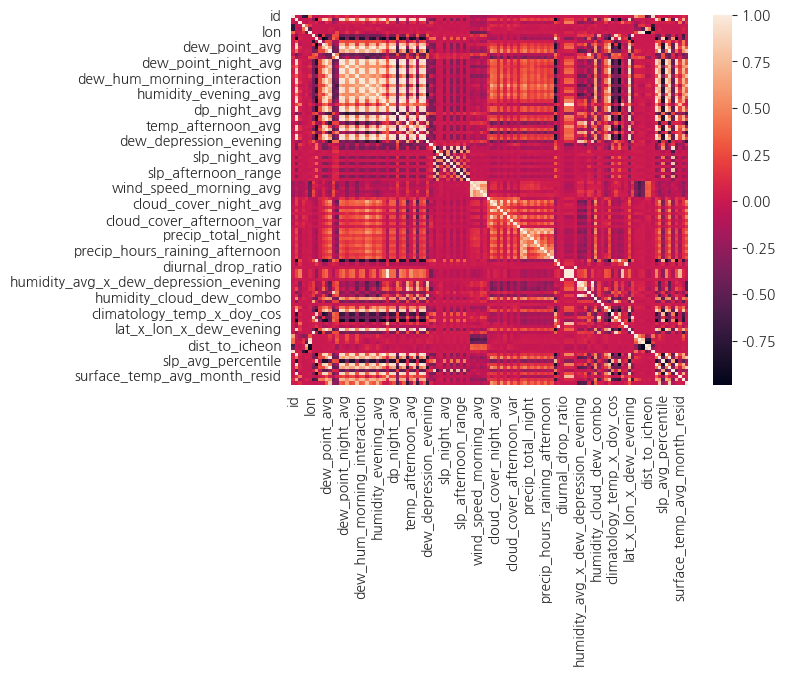

In [26]:
corr = train_df.corr()
sns.heatmap(corr)

> Export

In [27]:
# export df
train_df.to_csv("./input/processed/train_df_final_v5.csv", index=False)
test_df.to_csv("./input/processed/test_df_final_v5.csv", index=False)

In [28]:
train_df.columns.to_list()

['id',
 'climatology_temp',
 'target',
 'elev',
 'lat',
 'lon',
 'doy_sin',
 'doy_cos',
 'day_of_year',
 'day_length',
 'dew_point_avg',
 'humidity_avg',
 'dew_point_range',
 'humidity_range',
 'dew_humidity_interaction',
 'dew_point_night_avg',
 'humidity_night_avg',
 'dew_hum_night_interaction',
 'dew_point_morning_avg',
 'humidity_morning_avg',
 'dew_hum_morning_interaction',
 'dew_point_afternoon_avg',
 'humidity_afternoon_avg',
 'dew_hum_afternoon_interaction',
 'dew_point_evening_avg',
 'humidity_evening_avg',
 'dew_hum_evening_interaction',
 'surface_temp_avg',
 'surface_temp_anomaly',
 'temp_night_avg',
 'dp_night_avg',
 'dew_depression_night',
 'temp_morning_avg',
 'dp_morning_avg',
 'dew_depression_morning',
 'temp_afternoon_avg',
 'dp_afternoon_avg',
 'dew_depression_afternoon',
 'temp_evening_avg',
 'dp_evening_avg',
 'dew_depression_evening',
 'temp_evening_minus_morning',
 'slp_avg',
 'slp_std',
 'pressure_tendency',
 'slp_night_avg',
 'slp_night_range',
 'slp_morning_avg